In [2]:
from qiskit import *
from torchvision import datasets, transforms
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, normalize
from qiskit.circuit import ParameterVector, Parameter
from qiskit.algorithms.optimizers import SPSA, ADAM, COBYLA
from qiskit import execute
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import Statevector
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs

In [66]:
# Concentrating on the first 100 samples
n_samples = 50

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))
# Leaving only labels 0 and 1
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples],
                np.where(X_train.targets == 1)[0][:n_samples])

x_train = np.array([X_train[i][0].numpy() for i in idx])
y_train = np.array([X_train[i][1] for i in idx])

x_train, y_train = shuffle(x_train, y_train, random_state=42)

In [67]:
n_samples = 10

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

x_test = np.array([X_test[i][0].numpy() for i in idx])
y_test = np.array([X_test[i][1] for i in idx])

x_test, y_test = shuffle(x_test, y_test, random_state=42)

In [68]:
print(x_train.shape)
print(x_test.shape)

h = x_train.shape[2]
w = x_train.shape[3]

x_train = x_train.reshape(-1,h,w)
x_test = x_test.reshape(-1,h,w)

print(x_train.shape)
print(x_test.shape)

(100, 1, 28, 28)
(20, 1, 28, 28)
(100, 28, 28)
(20, 28, 28)


In [69]:
def display_images(x, y):
    n_samples_show = 10
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

    while n_samples_show > 0:
        image, target = x[n_samples_show], y[n_samples_show]

        axes[n_samples_show - 1].imshow(image, cmap='gray')
        axes[n_samples_show - 1].set_xticks([])
        axes[n_samples_show - 1].set_yticks([])
        axes[n_samples_show - 1].set_title(format(target))

        n_samples_show -= 1

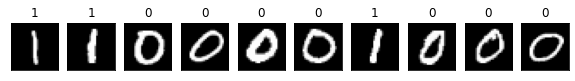

In [70]:
display_images(x_train, y_train)

In [71]:
x_train = x_train.reshape(-1,h*w)
x_test = x_test.reshape(-1,h*w)

In [72]:
n_components = 16
pca = PCA(n_components)
pca.fit(x_train)
print("Cumulative sum for train:", np.cumsum(pca.explained_variance_ratio_ * 100)[-1])
x_train = pca.transform(x_train)

pca.fit(x_test)
print("Cumulative sum for test:", np.cumsum(pca.explained_variance_ratio_ * 100)[-1])
x_test = pca.transform(x_test)

Cumulative sum for train: 83.05244
Cumulative sum for test: 98.82273


In [73]:
print(x_train.shape)
print(x_test.shape)

(100, 16)
(20, 16)


In [74]:
x_train = normalize(x_train)
x_test = normalize(x_test)

In [75]:
# threshold = 0

# x_train = np.array(x_train > threshold, dtype=np.float32)
# x_test = np.array(x_test > threshold, dtype=np.float32)

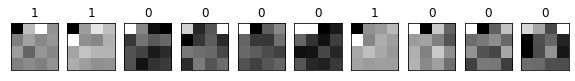

In [76]:
display_images(x_train.reshape(-1,4,4),y_train)

In [17]:
print(x_train.max(),x_train.min())

0.86018723 -0.89008534


In [97]:
X,y = make_blobs(n_samples=100,n_features=2,centers=2,random_state=42)

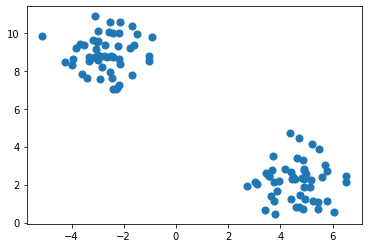

In [98]:
plt.scatter(X[:,0], X[:,1], s = 50)

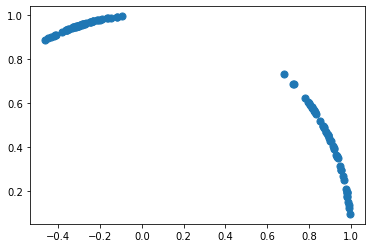

In [99]:
X = normalize(X)
plt.scatter(X[:,0], X[:,1], s = 50)

In [ ]:
X.max(),X.min()

In [16]:
def cirq_layer(qc, readout, data_qubits, gate_name):
    theta_list = ParameterVector('θ' + gate_name, length=len(data_qubits))
    if gate_name == 'xx':
        for i in data_qubits:
            qc.rxx(theta_list[i-1], i, readout)
    elif gate_name == 'zz':
        for i in data_qubits:
            qc.rzz(theta_list[i-1], i, readout)
    else:
        raise ValueError("gate name must be either xx or zz")
    return qc

In [41]:
# cluster state
def cluster_state_circuit(bits):
    qc = QuantumCircuit(bits)
    bits = list(range(bits))
    qc.h(bits)
    for this_bit, next_bit in zip(bits, bits[1:]):
        qc.cz(this_bit, next_bit)
    if(len(bits)!= 2):
        qc.cz(bits[0], bits[-1])
    return qc

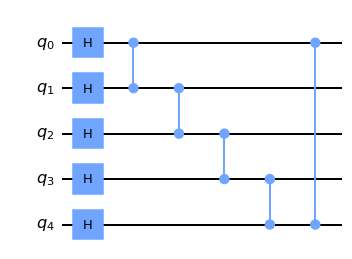

In [43]:
cluster_state_circuit(5).draw('mpl')

In [19]:
def one_qubit_unitary(thetas):
    qc = QuantumCircuit(1)
    qc.rx(thetas[0], 0)
    qc.ry(thetas[1], 0)
    qc.rz(thetas[2], 0)
    return qc

def two_qubit_unitary(thetas):
    qc = QuantumCircuit(2)
    qc = qc.compose(one_qubit_unitary(thetas[0:3]), [0])
    qc = qc.compose(one_qubit_unitary(thetas[3:6]), [1])
    qc.rzz(thetas[6],0, 1)
    qc.ryy(thetas[7],0, 1)
    qc.rxx(thetas[8],0, 1)
    qc = qc.compose(one_qubit_unitary(thetas[9:12]), [0])
    qc = qc.compose(one_qubit_unitary(thetas[12:]), [1])
    return qc


def two_qubit_pool(thetas):
    qc = QuantumCircuit(2)
    qc = qc.compose(one_qubit_unitary(thetas[0:3]), [1])
    qc = qc.compose(one_qubit_unitary(thetas[3:6]), [0])
    qc.cnot(0,1)
    qc = qc.compose(one_qubit_unitary(thetas[0:3]).inverse(), [1])
    return qc

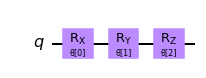

In [20]:
one_qubit_unitary(ParameterVector('θ', length=3)).draw('mpl')

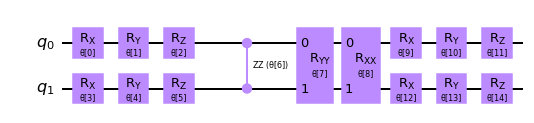

In [21]:
two_qubit_unitary(ParameterVector('θ', length=15)).draw('mpl')

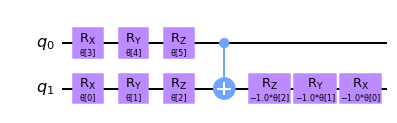

In [22]:
two_qubit_pool(ParameterVector('θ', length=6)).draw('mpl')

In [23]:
def quantum_conv_circuit(bits, thetas):
    qc = QuantumCircuit(bits)
    bits = list(range(bits))
    for first, second in zip(bits[0::2], bits[1::2]):
        qc = qc.compose(two_qubit_unitary(thetas), [first,second])
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        qc = qc.compose(two_qubit_unitary(thetas), [first, second])
    return qc

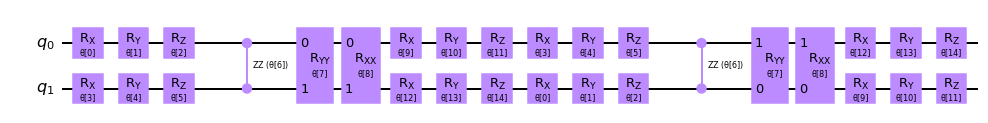

In [46]:
quantum_conv_circuit(2, ParameterVector('θ', length=15)).draw('mpl')

In [25]:
def quantum_pool_circuit(sources, sinks, thetas):
    qc = QuantumCircuit(len(sources) + len(sinks))
    for source, sink in zip(sources, sinks):
        qc = qc.compose(two_qubit_pool(thetas), [source, sink])
    return qc

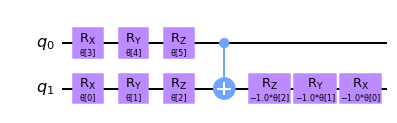

In [49]:
quantum_pool_circuit(list(range(1)), list(range(1,2)), ParameterVector('θ', length=6)).draw('mpl')

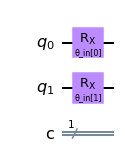

In [30]:
n = 2
backend = AerSimulator()

# Data encoding
in_thetas = ParameterVector('θ_in', length=n)
feature_map = QuantumCircuit(n,1)
for i in range(n):
    feature_map.rx(in_thetas[i], i)
feature_map.draw('mpl')

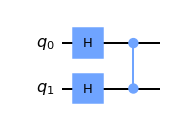

In [44]:
# cluster state
cluster_qc = cluster_state_circuit(n)
cluster_qc.draw('mpl')

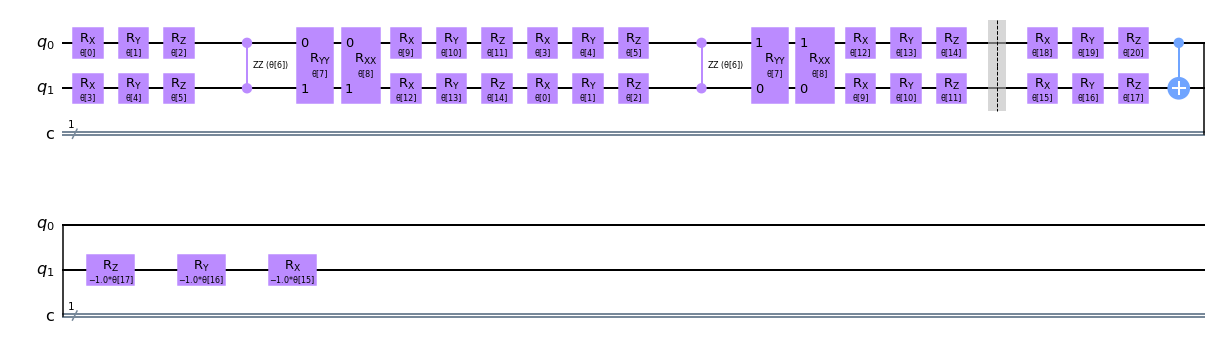

In [54]:
# variational circuit
thetas = ParameterVector('θ', length=21)
var_form = QuantumCircuit(n,1)
var_form = var_form.compose(quantum_conv_circuit(n,thetas[0:15]), [0,1])
var_form.barrier()
var_form = var_form.compose(quantum_pool_circuit([0], [1], thetas[15:21]))
var_form.draw('mpl')

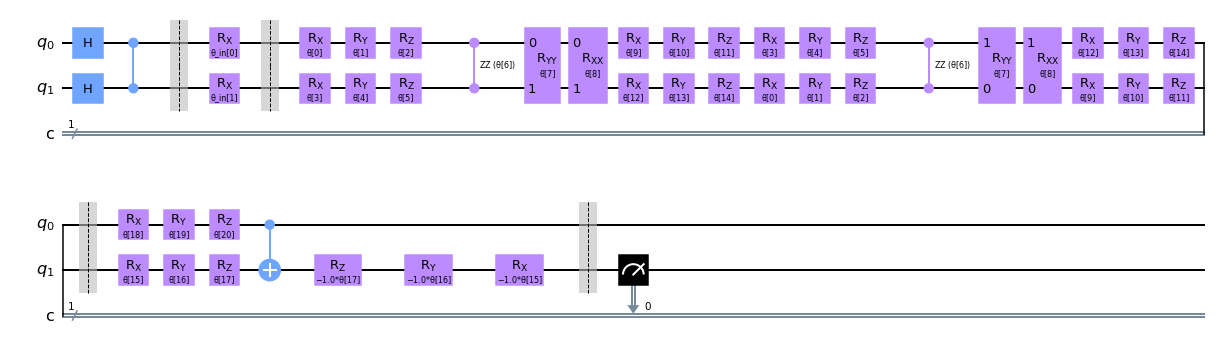

In [56]:
circuit = QuantumCircuit(n,1)
circuit = circuit.compose(cluster_qc)
circuit.barrier()
circuit = circuit.compose(feature_map)
circuit.barrier()
circuit = circuit.compose(var_form)
circuit.barrier()
circuit.measure(1,0)
circuit.draw('mpl')

In [137]:
# n = n_components
# backend = AerSimulator()

# # Data encoding
# in_thetas = ParameterVector('θ_in', length=n)
# feature_map = QuantumCircuit(n,1)
# for i in range(n):
#     feature_map.rx(in_thetas[i], i)

# # cluster state
# cluster_qc = cluster_state_circuit(n)

# # variational circuit
# thetas = ParameterVector('θ', length=64)
# Range = list(range(n))
# var_form = QuantumCircuit(n,1)
# var_form = var_form.compose(quantum_conv_circuit(n,thetas[0:15]), Range)
# var_form = var_form.compose(quantum_pool_circuit(Range[:8], Range[8:], thetas[15:21]), Range)
# var_form = var_form.compose(quantum_conv_circuit(n//2,thetas[21:36]), Range[8:])
# var_form = var_form.compose(quantum_pool_circuit(Range[:4], Range[4:8], thetas[36:42]), Range[8:])
# var_form = var_form.compose(quantum_conv_circuit(n//4,thetas[42:57]), Range[12:])
# var_form = var_form.compose(quantum_pool_circuit(Range[:3], [Range[3]], thetas[57:63]), Range[12:])

# circuit = QuantumCircuit(n,1)
# circuit = circuit.compose(cluster_qc)
# circuit = circuit.compose(feature_map)
# circuit = circuit.compose(var_form)
# circuit.measure(15, 0)

In [27]:
# circuit.draw('mpl')

In [57]:
circuit.num_parameters

23

In [65]:
def circuit_parameters(x, variational):
    parameters = {}
    for i, p in enumerate(feature_map.parameters):
        parameters[p] = x[i]
    for i, p in enumerate(var_form.parameters):
        parameters[p] = variational[i]
    return parameters

In [66]:
def assign_label(bitstring):
    hamming_weight = sum([int(k) for k in list(bitstring)])
    odd = hamming_weight & 1
    if odd:
        return 1
    else:
        return 0

In [67]:
def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = int(bitstring)
        probabilities[label] += counts / shots
    return probabilities

In [68]:
def classification_probability(data, variational):
    qc_list = [circuit.assign_parameters(circuit_parameters(d,variational)) for d in data]
    results =  execute(qc_list, backend).result()
    classification = [label_probability(results.get_counts(c)) for c in qc_list]
    return classification

In [69]:
costs = []
accuracies = []

In [70]:
def cross_entropy_loss(predictions, expected):
    p = predictions.get(expected)
    return -(expected*np.log(p)+(1-expected)*np.log(1-p))

def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)
    cost = 0
    acc = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
        if (classification[0] >= classification[1]) and labels[i] == 0:
            acc +=1
        elif (classification[1]) >= classification[0] and (labels[i] == 1):
            acc += 1
    cost /= len(data)
    costs.append(cost)
    acc /= len(labels)
    accuracies.append(acc)
    print('cost:', np.around(cost,4), 'acc: ',np.around(acc, 4))
    return cost

In [94]:
optimizer = SPSA(maxiter=100)
initial_point = np.random.uniform(-np.pi, np.pi, circuit.num_parameters)
objective_function = lambda variational: cost_function(X,
                                                       y,
                                                       variational)

In [95]:
# Run the optimization
opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

cost: 1.2373 acc:  0.965
cost: 0.9309 acc:  0.085
cost: 1.7219 acc:  0.5
cost: 1.0589 acc:  0.5
cost: 1.1982 acc:  0.5
cost: 0.7384 acc:  0.565
cost: 2.2052 acc:  0.5
cost: 0.8727 acc:  0.0
cost: 1.564 acc:  0.5
cost: 1.4479 acc:  0.5
cost: 1.1361 acc:  0.91
cost: 1.6731 acc:  0.5
cost: 1.36 acc:  0.5
cost: 1.4527 acc:  0.5
cost: 1.0848 acc:  0.5
cost: 2.3126 acc:  0.5
cost: 1.1864 acc:  0.5
cost: 1.7945 acc:  0.5
cost: 1.1064 acc:  0.185
cost: 0.7531 acc:  0.875
cost: 0.975 acc:  0.455
cost: 1.7794 acc:  0.5
cost: 0.8946 acc:  0.85
cost: 1.4162 acc:  0.5
cost: 1.3878 acc:  0.5
cost: 2.9942 acc:  0.5
cost: 1.9916 acc:  0.5
cost: 1.0374 acc:  0.5
cost: 0.6211 acc:  0.05
cost: 0.9966 acc:  0.995
cost: 1.1115 acc:  0.5
cost: 1.7287 acc:  0.5
cost: 1.3556 acc:  0.5
cost: 1.7796 acc:  0.5
cost: 2.0108 acc:  0.58
cost: 1.3041 acc:  0.5
cost: 1.1956 acc:  0.5
cost: 1.5777 acc:  0.5
cost: 0.9902 acc:  0.44
cost: 1.1718 acc:  0.5
cost: 0.9741 acc:  0.525
cost: 0.8906 acc:  0.51
cost: 1.0344 acc

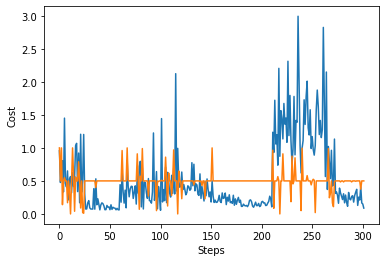

In [96]:
fig = plt.figure()
plt.plot(costs)
plt.plot(accuracies)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [435]:
def score_classifier(data, labels, variational):
    probability = classification_probability(data, variational)

    prediction = [0 if p[0] >= p[1] else 1 for p in probability]
    
    accuracy = 0
    for i, p in enumerate(probability):
        if (p[0] >= p[1]) and (labels[i] == 0):
            accuracy += 1
        elif (p[1]) >= p[0] and (labels[i] == 1):
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

accuracy, prediction = score_classifier(x_test, y_test, opt_var)
accuracy

0.5